Notebook to explore the possibility of internal wave beams near the Fraser River banks and Rich's boundary current.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline

from nowcast import analyze, research_VENUS
from salishsea_tools import viz_tools

In [2]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy = grid.variables['Bathymetry']
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

In [3]:
def load_uv(day,mesh):
    datestr=day.strftime('%d%b%y').lower()
    datenum = day.strftime('%Y%m%d')


    f = nc.Dataset('/results/SalishSea/nowcast/{}/SalishSea_1h_{}_{}_grid_U.nc'.format(datestr, datenum,
                                                                                       datenum))
    u =f.variables['vozocrtx'][:]
    umask = mesh.variables['umask'][:]
    umask = umask +np.zeros(u.shape)
    umask = np.abs(umask-1)
    u=np.ma.masked_array(u,mask=umask)

    f = nc.Dataset('/results/SalishSea/nowcast/{}/SalishSea_1h_{}_{}_grid_V.nc'.format(datestr, datenum,
                                                                                       datenum))
    v =f.variables['vomecrty'][:]
    vmask = mesh.variables['vmask'][:]
    vmask = vmask +np.zeros(v.shape)
    vmask = np.abs(vmask-1)
    v=np.ma.masked_array(v,mask=vmask)
    
    time_counter = f.variables['time_counter']
    dates = nc.num2date(time_counter[:],time_counter.units)

    return u,v, dates

In [4]:
def load_ssh(day,mesh):
    
    datestr=day.strftime('%d%b%y').lower()
    datenum = day.strftime('%Y%m%d')


    f = nc.Dataset('/results/SalishSea/nowcast/{}/SalishSea_1h_{}_{}_grid_T.nc'.format(datestr, datenum,
                                                                                       datenum))
    ssh =f.variables['sossheig'][:]
    tmask = mesh.variables['tmask'][:,0,:,:]
    tmask = tmask +np.zeros(ssh.shape)
    tmask = np.abs(tmask-1)
    ssh=np.ma.masked_array(ssh,mask=tmask)

    return ssh

In [5]:
def baroclinic_velocities(u,v,mesh):
    
    e3u = mesh.variables['e3u'][0,:,:,:]
    umask = mesh.variables['umask'][0,:,:,:]

    e3v = mesh.variables['e3v'][0,:,:,:]
    vmask = mesh.variables['vmask'][0,:,:,:]
    
    depav_u= analyze.depth_average_mask(u,e3u,umask,1)
    depav_u = np.expand_dims(depav_u,1)
    ubc = u-depav_u
    
    depav_v= analyze.depth_average_mask(v,e3v,vmask,1)
    depav_v = np.expand_dims(depav_v,1)
    vbc = v-depav_v
    
    return ubc, vbc

In [6]:
day = datetime.datetime(2015,4,3)
u,v, dates  = load_uv(day,mesh)
ubc,vbc = baroclinic_velocities(u,v,mesh)

In [7]:
ssh = load_ssh(day,mesh)
dept = mesh.variables['gdept'][0,:,:,:]
dept0 =mesh.variables['gdept_0'][0,:]

In [8]:
SITES = research_VENUS.SITES['VENUS']

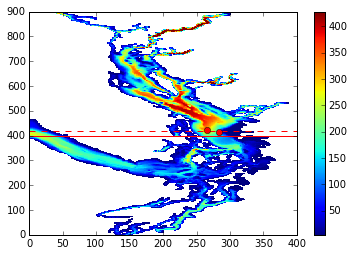

In [9]:
j1 = 400
j2 = 420

plt.pcolormesh(bathy[:])
plt.plot([0,400],[j1,j1], 'r-')
plt.plot([0,400],[j2,j2], 'r--')
plt.plot(SITES['Central']['i'],SITES['Central']['j'],'ro')
plt.plot(SITES['East']['i'],SITES['East']['j'],'ro')
plt.colorbar()

In [10]:
def compare_beams_current(t,k,ubc,vbc,u,v,bathy,j1,j2,st=5,xmin=240,xmax=320,ymin=370,ymax=460,
                         zmin=0,zmax=350,vmin=0,vmax=0.05,scalebt = 5, scalebc=3):
    
    u_plane,v_plane = viz_tools.unstagger(u[t,k,:,:],v[t,k,:,:])
    
    ubct, vbct = viz_tools.unstagger(ubc[t,:,:,:], vbc[t,:,:,:])
    
    kebc= 0.5*(ubct**2+vbct**2)
    depth = dept0[k]
    date = dates[t]
    fig,axs = plt.subplots(2,2,figsize=(15,8))

    for ax, j in zip(axs[:,0],[j2,j1]):
        x=np.arange(kebc.shape[-1])
        xx,_ = np.meshgrid(x,np.arange(kebc.shape[0]))
        msh = ax.pcolormesh(xx, dept0,np.squeeze(kebc[:,j,:]),cmap='hot',
                           vmin=vmin,vmax=vmax)
        cbar = plt.colorbar(msh,ax=ax)
        cbar.set_label('Baroclinic Kinetic Energy (m^2/s^2)')
        ax.set_xlim([xmin,xmax])
        ax.set_ylim([zmax,zmin])
        ax.set_ylabel('Depth (m)')
        ax.set_xlabel('x')
        ax.plot([xmin,xmax],[depth,depth],'--b')
        ax.set_title('{} through y = {}'.format(date.strftime('%d-%m-%Y %H:%M'), j))
        for stn in ['Central', 'East']:
            ax.plot([SITES[stn]['i'], SITES[stn]['i']], [zmin,zmax],'r--')
        
    for ax, up,vp, scale in zip(axs[:,1], [u_plane,ubct[k,:,:]], [v_plane,vbct[k,:,:]],[scalebt, scalebc]):
        x=np.arange(kebc.shape[-1])
        y=np.arange(kebc.shape[-2])
        q=ax.quiver(x[::st],y[::st],up[::st,::st],vp[::st,::st],color='k',scale=scale)
        ax.quiver
        ax.set_xlim([xmin,xmax])
        ax.set_ylim([ymin,ymax])
        ax.contour(bathy[:],[depth],colors='gray')
        ax.contour(bathy[:].data,[0],colors='k')
        ax.set_ylabel('y')
        ax.set_xlabel('x')
        ax.plot([xmin,xmax],[j1,j1],'-r')
        ax.plot([xmin,xmax],[j2,j2],'--r')
        for stn in ['Central', 'East']:
            ax.plot(SITES[stn]['i'], SITES[stn]['j'],'ro')
        ax.quiverkey(q, xmax-10, 430, 0.5, '0.5 m/s', coordinates='data', labelcolor='black')

    axs[0,1].set_title('Full current at depth {0:.3g} m'.format(depth))
    axs[1,1].set_title('Baroclinic current at depth {0:.3g} m'.format(depth))

        
    return fig
        

In [11]:
def plot_ssh(ssh,i,j,t,location):
    fig,ax = plt.subplots(1,1,figsize=(8,3))
    
    ax.plot(dates, ssh[:,j,i])
    ax.set_title('sea surface height at {} on {}'.format(location,dates[0].strftime('%d-%m-%Y')))
    ax.set_ylabel('ssh (m)')

    ax.plot([dates[t],dates[t]],[-3,3],'r-')
    return fig

### Turn to ebb tide

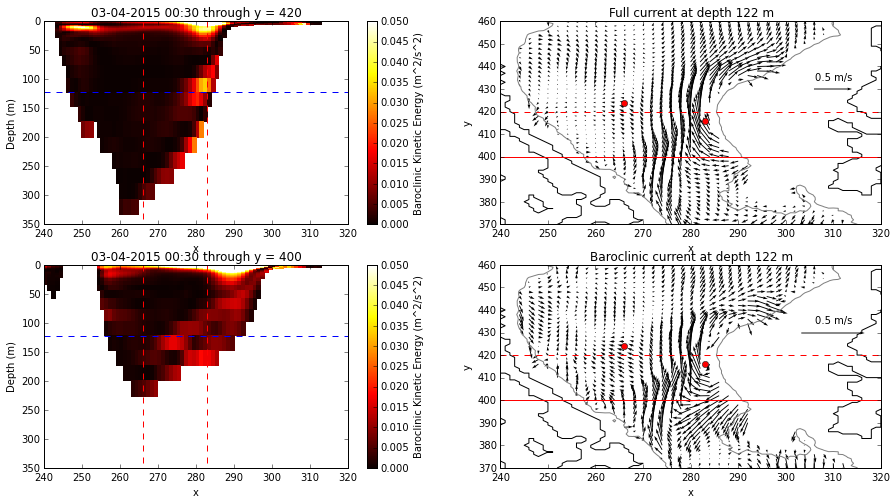

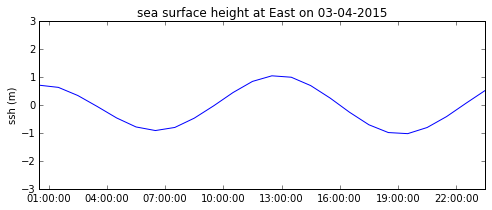

In [12]:
t=0
k=27
fig = compare_beams_current(t,k,ubc,vbc,u,v,bathy,j1,j2,st=2)
loc='East'
fig = plot_ssh(ssh,SITES[loc]['i'],SITES[loc]['j'],t, loc)

y=400 slice:

Clear beam originating from the banks. Baroclinic currents are directed away from banks (negative x direction) at z=122m.  My hypothesis is that this beam is generate from the freshh water interacting with the steep topography. Slope of beam approximately matches with theoretical slope.

y = 420 slice:

There is no coherent beam, but there is a blob of increased baroclinic kinetic energy at about x=283 (East node position). Baroclinic currents are mostly in the same direction as full current. (Rich's current?). Weird that the full current is not ebbing at this depth.

If we have an inflow current like Rich's, at what depth would we expect it to propoagte? What is its density compared to the surrounding density?

### Max Ebb

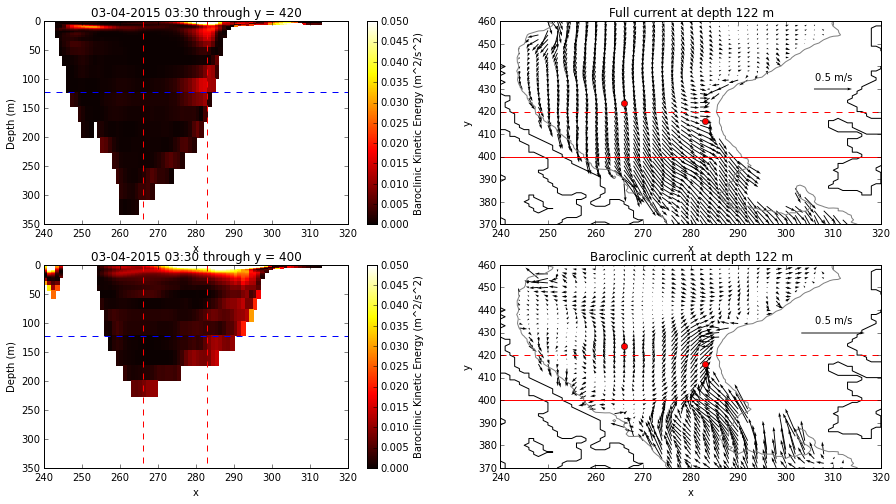

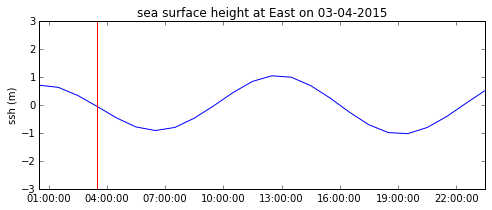

In [13]:
t=3
k=27
fig = compare_beams_current(t,k,ubc,vbc,u,v,bathy,j1,j2,st=2)
loc='East'
fig = plot_ssh(ssh,SITES[loc]['i'],SITES[loc]['j'],t, loc)

y=400 slice:

Beam is diminishing. Full current is ebbing, looking to pass over a sill. Baroclinic current is opposite direction. So does that mean the full current is much lower than the barotropic current at this depth. Topographic blocking or other effects?

y = 420 slice:

Blob of increase baroclinic ke is still there. Baroclinic current is still directed along the isboaths, in the flood direction. Remants of the inflow current?


### Turn to flood

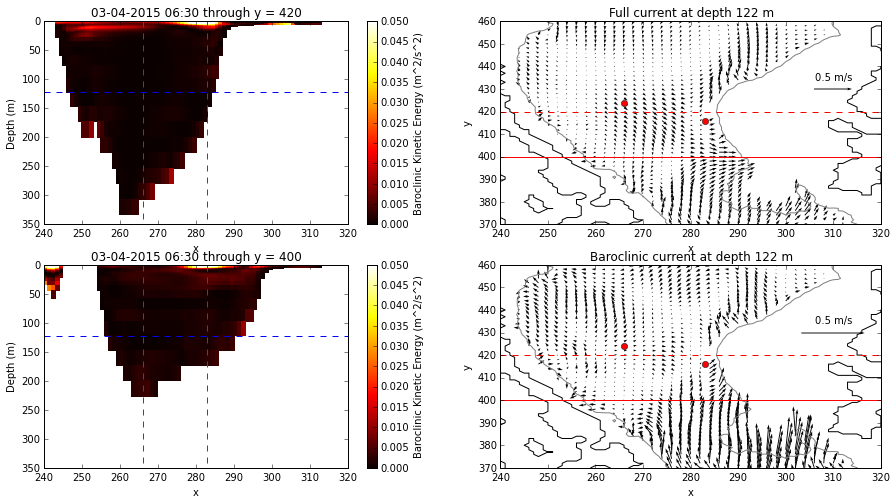

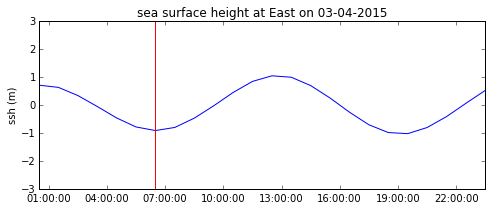

In [14]:
t=6
k=27
fig = compare_beams_current(t,k,ubc,vbc,u,v,bathy,j1,j2,st=2)
loc='East'
fig = plot_ssh(ssh,SITES[loc]['i'],SITES[loc]['j'],t, loc)

y=400 slice:

No sign of beam. 

y = 420 slice:

No sign of ke blob. No evidence of inflow current in full currents or baroclinic.

### Max flood

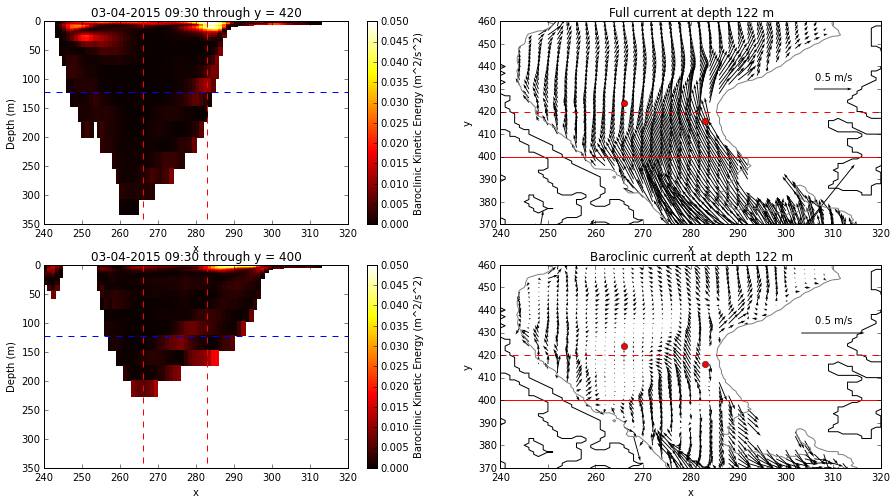

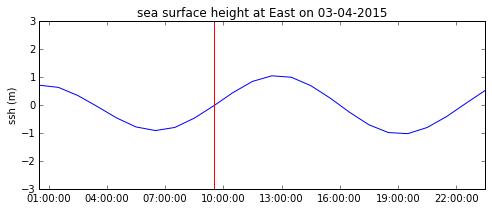

In [15]:
t=9
k=27
fig = compare_beams_current(t,k,ubc,vbc,u,v,bathy,j1,j2,st=2)
loc='East'
fig = plot_ssh(ssh,SITES[loc]['i'],SITES[loc]['j'],t, loc)

y=400 slice:

Some evidence of a weak beam. Baroclinic currents are in opposite direction of full currents. It seems possible that the southern sill could be a generation site for internal waves but this slice wouldn't show them. 

y = 420 slice:

It appears as though there could be a beam from the slopes but at this depth the currents are aligned with the isobaths so I'm not sure of the generation mechanism. Baroclinic currents are directed away from the coast towards the deep water.

### Turn to ebb

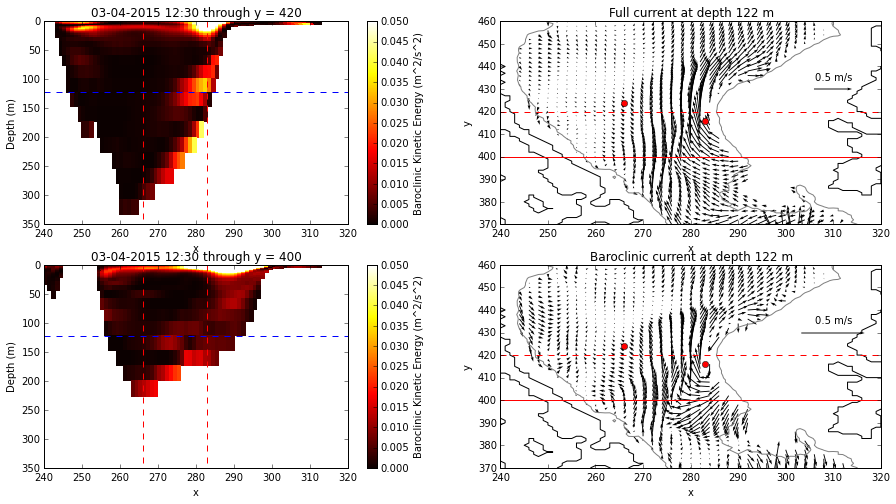

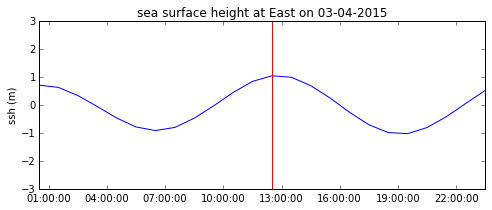

In [16]:
t=12
k=27
fig = compare_beams_current(t,k,ubc,vbc,u,v,bathy,j1,j2,st=2)
loc='East'
fig = plot_ssh(ssh,SITES[loc]['i'],SITES[loc]['j'],t, loc)

y=400 slice:

Beam like structure is back, although not as coherent. Baroclinic currents are directed away from isobath. 

y = 420 slice:

KE blob is back. Again, it sort of looks like a beam, but what explains the maximum at about 100m? Currents support the inflow idea.

### Max Ebb

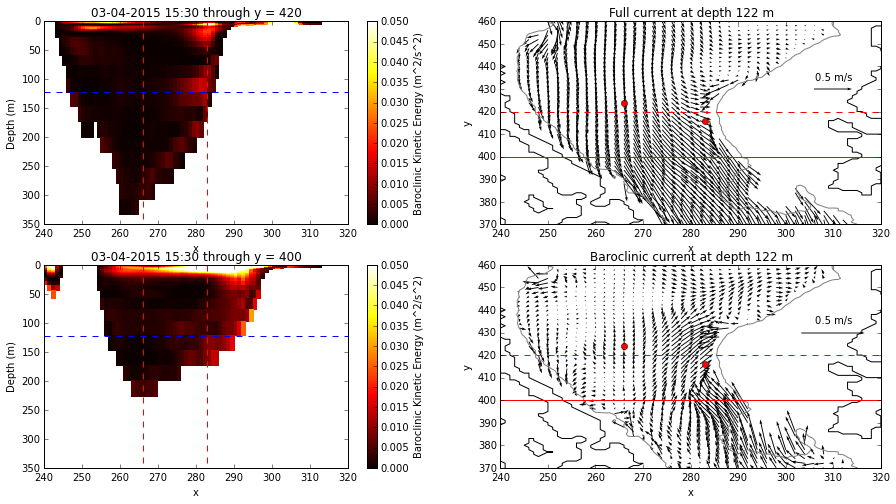

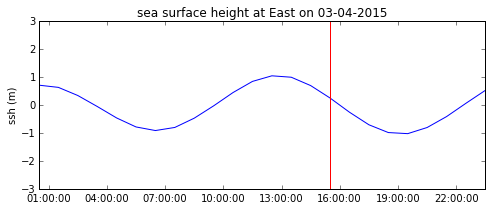

In [17]:
t=15
k=27
fig = compare_beams_current(t,k,ubc,vbc,u,v,bathy,j1,j2,st=2)
loc='East'
fig = plot_ssh(ssh,SITES[loc]['i'],SITES[loc]['j'],t, loc)

### Turn to flood

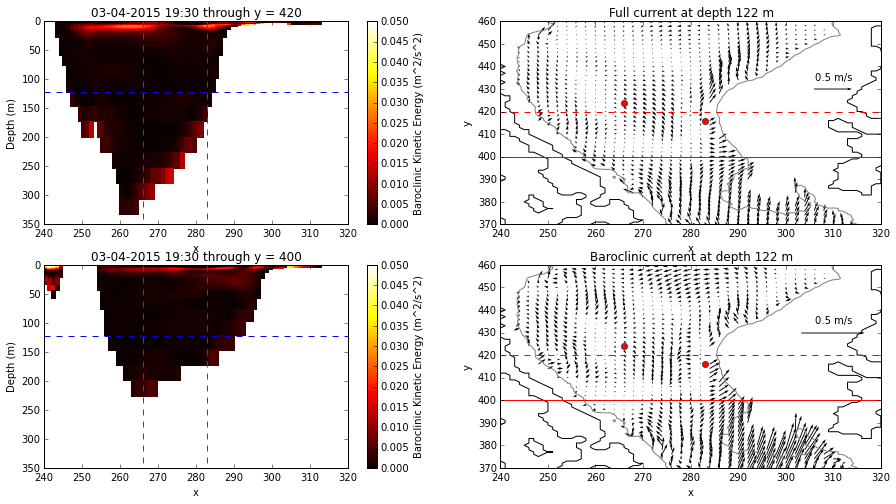

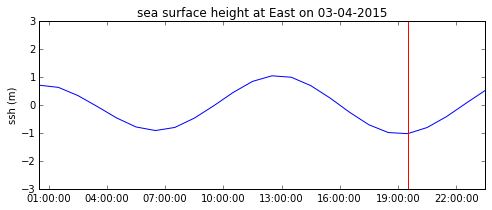

In [18]:
t=19
k=27
fig = compare_beams_current(t,k,ubc,vbc,u,v,bathy,j1,j2,st=2)
loc='East'
fig = plot_ssh(ssh,SITES[loc]['i'],SITES[loc]['j'],t, loc)

### Max flood

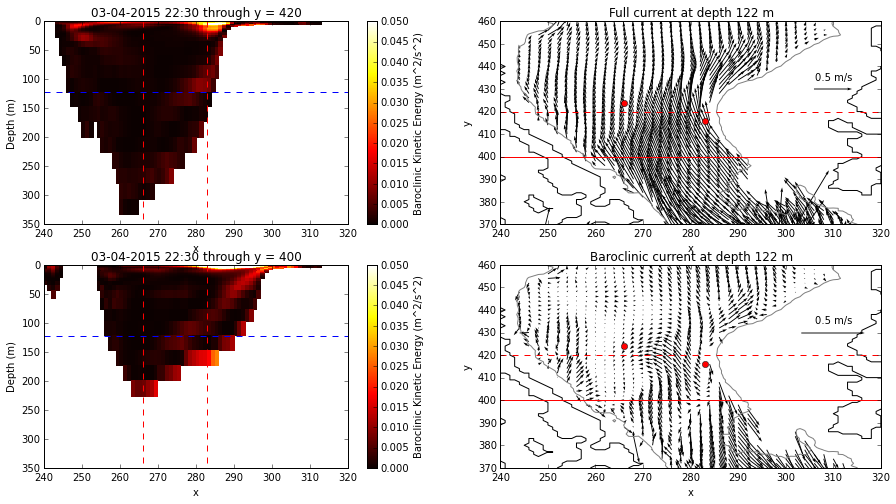

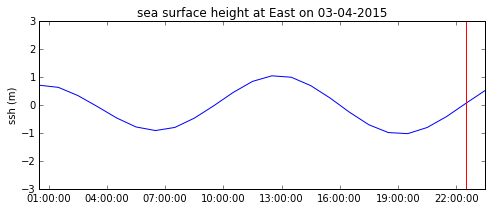

In [19]:
t=22
k=27
fig = compare_beams_current(t,k,ubc,vbc,u,v,bathy,j1,j2,st=2)
loc='East'
fig = plot_ssh(ssh,SITES[loc]['i'],SITES[loc]['j'],t, loc)